# Introduction
This is a Graph Convolutional Networks (GCN) to predict adsorption energy by density of states of mentals.

# Function

In [2]:
import sys
import pickle
import spektral
import visualkeras
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow.keras import layers

from spektral import models
from spektral.models.gnn_explainer import GNNExplainer
from spektral.data import Graph, Dataset, DisjointLoader
from spektral.layers import ECCConv, GlobalSumPool, GlobalAvgPool

from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.layers import (
    Input,
    BatchNormalization,
    Dropout,
    Dense,
    AveragePooling1D,
    Concatenate,
    Conv1D,
    Flatten,
)
from tensorflow.keras.models import Model

sys.executable

# TSNE PCA
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

/home/zwbai/miniconda3/envs/gcn/lib/python3.9/site-packages/networkx/utils/backends.py:135: RuntimeWarning: networkx backend defined more than once: nx-loopback
  backends.update(_get_backends("networkx.backends"))


In [3]:
tf.config.run_functions_eagerly(True)
print(tf.executing_eagerly())

True


# Load Data

In [4]:
class MyGraphDataset(Dataset):
    """
    A dataset of density of states of mentals
    """

    def __init__(self, graph_list, **kwargs):
        self.graph_list = graph_list
        super().__init__(**kwargs)

    def download(self):
        if self.path is None:
            print("self.path is None")
        else:
            with open(self.path, "wb") as file:
                pickle.dump(self.graph_list, file)

    def read(self):
        # We must return a list of Graph objects
        output = []
        for i in range(len(self.graph_list)):
            output.append(self.graph_list[i])
        return output

    def __len__(self):
        return len(self.graph_list)

    def __getitem__(self, index):
        return self.graph_list[index]

In [5]:
# 从文件中提取数据
file_path = "/home/zwbai/work/ocp-main/ocp_pre/ocp_main/main/shear/vasp_cal/dos_energy_data.pkl"
with open(file_path, "rb") as file:
    dataset1 = pickle.load(file)

print(dataset1)  # 输出：[1, 2, 3, 4, 5]
dataset1[0].x.shape

MyGraphDataset(n_graphs=120)


(8, 4000)

In [6]:
# 从文件中提取数据
file_path = "/home/zwbai/work/ocp-main/ocp_pre/ocp_main/main/shear2/vasp_cal/dos_energy_data.pkl"
with open(file_path, "rb") as file:
    dataset2 = pickle.load(file)

print(dataset2)  # 输出：[1, 2, 3, 4, 5]
dataset2[0].x.shape

MyGraphDataset(n_graphs=60)


(8, 4000)

In [7]:
# 从文件中提取数据
data_path = "/media/zwbai/DATA/dft/all/vasp_cal/"  # 当前文件执行的文件夹，包括输出和输入文件夹
dos_energy_data_file = data_path + "dos_energy_data.pkl"
with open(dos_energy_data_file, "rb") as file:
    dataset3 = pickle.load(file)

print(dataset3)  # 输出：[1, 2, 3, 4, 5]
dataset3[0].x.shape

MyGraphDataset(n_graphs=594)


(8, 4000)

In [8]:
# 从文件中提取数据
data_path = "/media/zwbai/DATA/dft/alloy_copy/vasp_cal/"  # 当前文件执行的文件夹，包括输出和输入文件夹
dos_energy_data_file = data_path + "dos_energy_data.pkl"
with open(dos_energy_data_file, "rb") as file:
    dataset4 = pickle.load(file)

print(dataset4)  # 输出：[1, 2, 3, 4, 5]
dataset4[0].x.shape

MyGraphDataset(n_graphs=567)


(8, 4000)

In [9]:
graph_data = []
for i in range(len(dataset1)):
    g = dataset1[i]
    graph_data.append(g)

for i in range(len(dataset2)):
    g = dataset2[i]
    graph_data.append(g)

for i in range(len(dataset3)):
    g = dataset3[i]
    graph_data.append(g)

for i in range(len(dataset4)):
    g = dataset4[i]
    graph_data.append(g)
    
dataset = MyGraphDataset(graph_data)
dataset

MyGraphDataset(n_graphs=1341)

In [10]:
dos_energy_data_file =  "/media/zwbai/DATA/dft/alloy_copy/vasp_cal/dos_energy_data_all.pkl"  # 保存数据
with open(dos_energy_data_file, "wb") as file:
    pickle.dump(dataset, file)

In [36]:
start = 180+66*11
dataset_y = []
for i in range(start,start+66):
    dataset_y.append(dataset[i].y)
min(dataset_y), max(dataset_y)

(-1.5741477999999791, -0.5778777999999978)

# Build GCN model

In [406]:
F = dataset.n_node_features  # Dimension of node features
S = dataset.n_edge_features  # Dimension of edge features
n_out = dataset.n_labels  # Dimension of the target
F, S, n_out

(4000, 4, 1)

In [407]:
learning_rate = 1e-4  # Learning rate
epochs = 40  # Number of training epochs
batch_size = 32  # Batch size

In [408]:
def dos_featurizer(length, channel):
    input_dos = Input(shape=(length, channel))  # 400, 5
    x1 = AveragePooling1D(pool_size=4, strides=4, padding="same")(input_dos)  # 窗口 步长
    x2 = AveragePooling1D(pool_size=16, strides=4, padding="same")(input_dos)
    x3 = AveragePooling1D(pool_size=64, strides=4, padding="same")(input_dos)
    x = Concatenate(axis=-1)([x1, x2, x3])  # 沿着最后一个轴拼接
    x = Conv1D(256, 64, activation="relu", padding="same", strides=2)(x)
    x = BatchNormalization()(x)
    x = Conv1D(128, 32, activation="relu", padding="same", strides=2)(x)
    x = AveragePooling1D(pool_size=3, strides=2, padding="same")(x)
    x = Conv1D(64, 16, activation="relu", padding="same", strides=2)(x)
    x = AveragePooling1D(pool_size=3, strides=2, padding="same")(x)
    x = Conv1D(32, 8, activation="relu", padding="same", strides=2)(x)
    x = AveragePooling1D(pool_size=3, strides=2, padding="same")(x)
    x = Conv1D(16, 8, activation="relu", padding="same", strides=2)(x)
    x = tf.squeeze(x)
    shared_model = Model(input_dos, x)
    return shared_model

In [409]:
def dos_featurizer2(length, channel):
    input_dos = Input(shape=(length, channel))  # 800, 5
    x1 = AveragePooling1D(pool_size=4, strides=4, padding="same")(input_dos)
    x2 = AveragePooling1D(pool_size=50, strides=4, padding="same")(input_dos)
    x3 = AveragePooling1D(pool_size=200, strides=4, padding="same")(input_dos)
    x = Concatenate(axis=-1)([x1, x2, x3])
    x = Conv1D(50, 20, activation="relu", padding="same", strides=4)(x)
    x = BatchNormalization()(x)
    x = Conv1D(75, 3, activation="relu", padding="same", strides=2)(x)
    x = AveragePooling1D(pool_size=3, strides=2, padding="same")(x)
    x = Conv1D(100, 3, activation="relu", padding="same", strides=2)(x)
    x = AveragePooling1D(pool_size=3, strides=2, padding="same")(x)
    x = Conv1D(125, 3, activation="relu", padding="same", strides=2)(x)
    x = AveragePooling1D(pool_size=3, strides=2, padding="same")(x)
    x = Conv1D(150, 3, activation="relu", padding="same", strides=2)(x)
    x = tf.squeeze(x)
    shared_model = Model(input_dos, x)
    return shared_model

In [410]:
channels = 5
length = int(F / channels)  # 400
shared_conv = dos_featurizer(length, channels)

In [411]:
class Net(Model):
    def __init__(self):
        super().__init__()
        self.share = shared_conv
        self.conv1 = ECCConv(256, activation="relu")
        self.conv2 = ECCConv(128, activation="relu")
        # self.conv3 = ECCConv(128, activation="relu")
        self.global_pool = GlobalAvgPool()
        self.dense0 = Dense(64)
        self.dense = Dense(n_out)

    def call(self, inputs):
        x, a, e, i = inputs
        x = tf.reshape(x, (-1, length, channels))
        x = shared_conv(x)  # dos feature

        x = self.conv1([x, a, e])
        x = self.conv2([x, a, e])
        output = self.global_pool([x, i])
        output = tf.keras.layers.Flatten()(output)
        output = self.dense0(output)
        output = self.dense(output)

        return output

In [412]:
GCN_model = Net()
GCN_model.layers

In [413]:
optimizer = Adam(learning_rate)
loss_fn = MeanSquaredError()

# Train/valid/test split
data = np.array(graph_data)
idxs = np.random.permutation(len(data))
split_va_te = int(0.90 * len(data))
idx_tr, idx_va = np.split(idxs, [split_va_te])
data_tr = data[idx_tr]
data_va = data[idx_va]

loader_tr = DisjointLoader(
    MyGraphDataset(data_tr), batch_size=batch_size, epochs=epochs
)
loader_va = DisjointLoader(MyGraphDataset(data_va), batch_size=1, epochs=1)

In [414]:
# Fit model
@tf.function(input_signature=loader_tr.tf_signature(), experimental_relax_shapes=True)
def train_step(inputs, target):
    with tf.GradientTape() as tape:
        predictions = GCN_model(inputs, training=True)
        loss = loss_fn(target, predictions) + sum(GCN_model.losses)
    gradients = tape.gradient(loss, GCN_model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, GCN_model.trainable_variables))
    return loss

In [415]:
istrain = False # 训练或者加载
if istrain:
    step = loss = 0
    for batch in loader_tr:
        step += 1
        loss += train_step(*batch)
        if step == loader_tr.steps_per_epoch:
            step = 0
            print("Loss: {}".format(loss / loader_tr.steps_per_epoch))
            loss = 0
    GCN_model.save_weights("./vasp_cal/GCN_model_weightas")  # 保存GCN權重
else:
    GCN_model.load_weights("./vasp_cal/GCN_model_weightas")  # 加载GCN权重

In [416]:
# Train/valid/test split
# data = np.array(graph_data)
# idxs = np.random.permutation(len(data))
# split_va_te = int(0.9 * len(data))
# idx_tr, idx_va = np.split(idxs, [split_va_te])
# data_tr = data[idx_tr]
# data_va = data[idx_va]

# Data loaders
loader_tr = DisjointLoader(MyGraphDataset(data_tr), batch_size=1, epochs=1)
loader_va = DisjointLoader(MyGraphDataset(data_va), batch_size=1, epochs=1)

In [417]:
# 对训练集进行预测
predictions = []
targets = []
for batch in loader_tr:
    output = GCN_model(batch[0], training=False)
    predictions.append(output)
    targets.append(batch[1])
predictions = np.concatenate(predictions, axis=0)
targets = np.concatenate(targets, axis=0)
# 组合预测值和真实值
data0 = np.concatenate([predictions, targets], axis=1)

# 对测试集进行预测
predictions = []
targets = []
for batch in loader_va:
    output = GCN_model(batch[0], training=False)
    predictions.append(output)
    targets.append(batch[1])
predictions = np.concatenate(predictions, axis=0)
targets = np.concatenate(targets, axis=0)

# 组合预测值和真实值
data1 = np.concatenate([predictions, targets], axis=1)

/home/zwbai/miniconda3/envs/gcn/lib/python3.9/site-packages/spektral/data/utils.py:221: UserWarning: you are shuffling a 'MyGraphDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


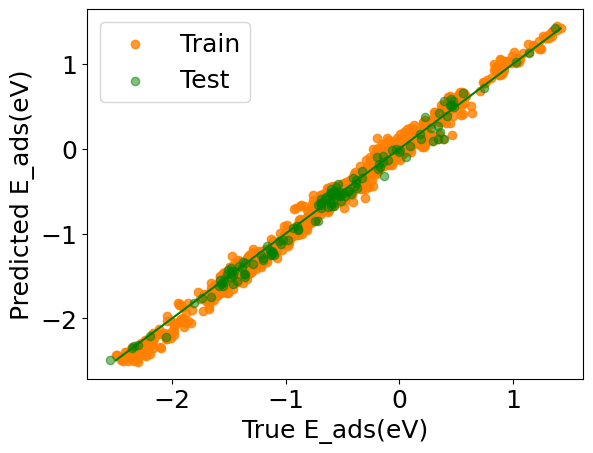

In [418]:
# 画图
plt.rcParams.update({"font.size": 18})

plt.scatter(data0[:, 1], data0[:, 0], color=(1, 0.5, 0, 0.8), label="Train")
plt.scatter(data1[:, 1], data1[:, 0], color=(0, 0.5, 0, 0.5), label="Test")

plt.plot(
    [min(data0[:, 1]), max(data0[:, 1])],
    [min(data0[:, 1]), max(data0[:, 1])],
    color="green",
)

plt.xlabel("True E_ads(eV)")
plt.ylabel("Predicted E_ads(eV)")
plt.legend()
plt.show()

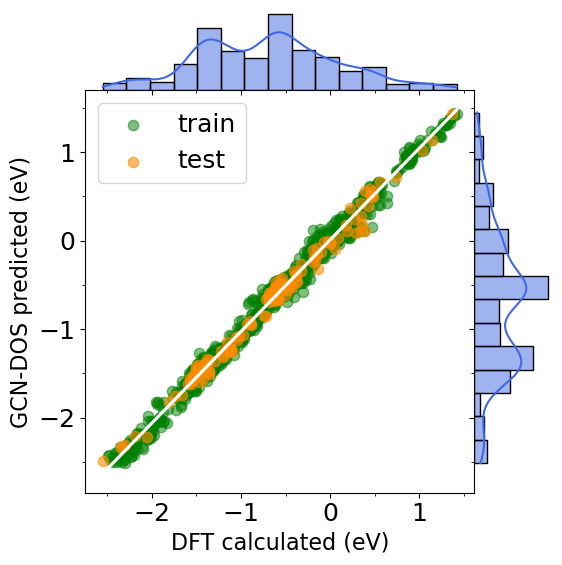

In [419]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

e_train, pre_train, e_test, pre_test = data0[:, 1], data0[:, 0], data1[:, 1], data1[:, 0]

# 将四列数据拼接为一个Pandas DataFrame
df1 = pd.concat([pd.DataFrame(e_train), pd.DataFrame(pre_train)], axis=1)
# 重置列索引（可选）
df1.columns = ['True','Predict']

df2 = pd.concat([pd.DataFrame(e_test), pd.DataFrame(pre_test)], axis=1)
# 重置列索引（可选）
df2.columns = ['True','Predict']

new_column_name = 'Species'
df1[new_column_name] = 'train'
df2[new_column_name] = 'test'
result = pd.concat([df1, df2], axis=0, ignore_index=True)

# plt.rcParams['font.family'] = 'Arial'
# 使用jointplot绘制联合分布图
plot = sns.jointplot(x='True', y='Predict',
                    data=result,
                    color='w',
                    kind='reg',
                    space=0.0,
                    ratio=5,
                    marginal_kws=dict(bins=15, color='royalblue'))

# 在联合分布图上添加自定义散点
# 注意：这里为df1和df2的散点图层分别指定了不同的标签
plot.ax_joint.scatter(df1['True'], df1['Predict'], alpha=0.5, s=55, label='train', color='g')
plot.ax_joint.scatter(df2['True'], df2['Predict'], alpha=0.6, s=55, label='test', color='darkorange')

# 设置主刻度和副刻度
# 获取x轴和y轴的轴对象
ax_x = plot.ax_marg_x
ax_y = plot.ax_marg_y

# 设置副刻度
# 假设我们想要在主刻度之间添加一个副刻度
# 首先，我们需要获取主刻度的位置
major_locator = ticker.MultipleLocator(1)  # 假设主刻度间隔为1
ax_x.xaxis.set_major_locator(major_locator)
ax_y.yaxis.set_major_locator(major_locator)

# 然后，我们创建一个副刻度定位器，其间隔为主刻度间隔的一半
minor_locator = ticker.MultipleLocator(0.5)  # 副刻度间隔为0.5
ax_x.xaxis.set_minor_locator(minor_locator)
ax_y.yaxis.set_minor_locator(minor_locator)
# 设置主刻度向内

# ax_x.tick_params(axis='x', which='both',  direction='in')
# ax_y.tick_params(axis='y', which='both',  direction='in')

# 添加图例
plot.ax_joint.legend(loc='upper left')
# 设置x和y轴的标签
plot.set_axis_labels('DFT calculated (eV)', 'GCN-DOS predicted (eV)', fontsize=16)

# 显示图表
plt.show()

In [353]:
import math
from sklearn.metrics import mean_squared_error

# 假设 y_pred 和 y_true 是两个长度相同的数组，分别代表预测值和真实值
# 计算均方根误差
rmse = math.sqrt(mean_squared_error(data0[:, 1], data0[:, 0]))
print("RMSE:", rmse)

RMSE: 0.08551373814094405


In [354]:
rmse = math.sqrt(mean_squared_error(data1[:, 1], data1[:, 0]))
print("RMSE:", rmse)

RMSE: 0.08743176459969833


In [355]:
class FeatureExtraction(Model):
    def __init__(self):
        super().__init__()
        self.share = shared_conv
        self.conv1 = ECCConv(128, activation="relu")
        self.conv2 = ECCConv(128, activation="relu")
        # self.conv3 = ECCConv(128, activation="relu")
        self.global_pool = GlobalAvgPool()
        self.dense0 = Dense(64)
        self.dense = Dense(n_out)

    def call(self, inputs):
        x, a, e, i = inputs
        x = tf.reshape(x, (-1, length, channels))
        x = shared_conv(x)

        x = self.conv1([x, a, e])
        feature1 = x  # 保存第一层卷积的特征
        x = self.conv2([x, a, e])
        feature2 = x  # 保存第二层卷积的特征
        output = self.global_pool([x, i])
        output = tf.keras.layers.Flatten()(output)
        output = self.dense0(output)
        feature3 = output
        output = self.dense(output)

        return output, feature1, feature2, feature3  # 返回输出和需要提取的特征\


Model_feature = FeatureExtraction()

In [356]:
from brokenaxes import brokenaxes
def plot_feature(X_embedded, z, broke=None):
    dim = X_embedded.shape[1]
    # 创建彩虹图的 colormap
    cmap = plt.get_cmap("rainbow")

    # 创建彩虹图的 colormap
    cmap = plt.get_cmap("viridis")

    # 设置合适的数值范围
    vmin = np.min(z)
    vmax = np.max(z)
    fig = plt.figure()

    if dim == 1:
        
        fig = plt.figure(figsize=(6,5))
        # ax = fig.add_subplot()
        # ax.scatter(X_embedded[:, 0], X_embedded[:, 1], c=z, cmap=cmap)
        # ax.set_xticks([])  # 移除x轴刻度
        # ax.set_yticks([])  # 移除y轴刻度
        if broke is None:
            ax = fig.add_subplot()
            ax.scatter(X_embedded[:, 0], z, c=z, cmap=cmap)
            # ax.set_xticks([])  # 移除x轴刻度
            # ax.set_yticks([])  # 移除y轴刻度
        else:
            ax = brokenaxes(xlims=broke[0],ylims=broke[1], hspace=.05, wspace=.05,despine=False)
            # 在brokenaxes对象上绘制散点图
            ax.scatter(X_embedded[:, 0], z, c=z, cmap=cmap)
        ax.set_xlabel('PCA-1')
        ax.set_ylabel('PCA-2')
        
        # ax = fig.add_subplot()
        # ax.scatter(X_embedded[:, 0], z, c=z, cmap=cmap)
        # # ax.set_xticks([])  # 移除y轴刻度
    elif dim == 2:
        fig = plt.figure(figsize=(6,5))
        # ax = fig.add_subplot()
        # ax.scatter(X_embedded[:, 0], X_embedded[:, 1], c=z, cmap=cmap)
        # ax.set_xticks([])  # 移除x轴刻度
        # ax.set_yticks([])  # 移除y轴刻度
        if broke is None:
            ax = fig.add_subplot()
            ax.scatter(X_embedded[:, 0], X_embedded[:, 1], c=z, cmap=cmap)
            # ax.set_xticks([])  # 移除x轴刻度
            # ax.set_yticks([])  # 移除y轴刻度
        else:
            ax = brokenaxes(xlims=broke[0],ylims=broke[1], hspace=.05, wspace=.05,despine=False)
            # 在brokenaxes对象上绘制散点图
            ax.scatter(X_embedded[:, 0], X_embedded[:, 1], c=z, cmap=cmap)
        ax.set_xlabel('PCA-1')
        ax.set_ylabel('PCA-2')
    elif dim == 3:
        ax = fig.add_subplot(111, projection="3d")
        ax.scatter(
            X_embedded[:, 0], X_embedded[:, 1], X_embedded[:, 2], c=targets, cmap=cmap
        )
        # ax.set_xticks([])  # 移除x轴刻度
        # ax.set_yticks([])  # 移除y轴刻度
        # ax.set_zticks([])  # 移除z轴刻度

    # ax.set_axis_off()  # 移除所有坐标轴刻度
    # plt.xticks(fontsize=20) #x轴刻度字体大小
    # plt.yticks(fontsize=20) #y轴刻度字体大小
    
    # sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
    # sm.set_array([])  # 设置一个空数组，传递给 colorbar
    # cbar = plt.colorbar(sm, ax=ax)
    # cbar.set_label("Adsorption Energy (eV)")

    # 设置图框线粗细
    # bwith = 2  # 边框宽度设置为2
    # TK = plt.gca()  # 获取边框
    # TK.spines["bottom"].set_linewidth(bwith)
    # TK.spines["left"].set_linewidth(bwith)
    # TK.spines["top"].set_linewidth(bwith)
    # TK.spines["right"].set_linewidth(bwith)

    # plt.show()



In [357]:
# Data loaders
loader_data = DisjointLoader(MyGraphDataset(data), batch_size=1, epochs=1)
predictions, targets, feature1, feature2, feature3 = [], [], [], [], []
for batch in loader_data:
    output, f1, f2, f3 = Model_feature(batch[0], training=False)
    predictions.append(output)
    feature1.append(f1)
    feature2.append(f2)
    feature3.append(f3)
    targets.append(batch[1])
predictions = np.concatenate(predictions, axis=0)
targets = np.concatenate(targets, axis=0)
# 组合预测值和真实值
data0 = np.concatenate([predictions, targets], axis=1)

/home/zwbai/miniconda3/envs/gcn/lib/python3.9/site-packages/spektral/data/utils.py:221: UserWarning: you are shuffling a 'MyGraphDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


In [358]:
fone = [f.numpy().reshape((1, -1))[0] for f in feature1]
fone = np.array(fone)
print(fone.shape)

ftwo = [f.numpy().reshape((1, -1))[0] for f in feature2]
ftwo = np.array(ftwo)
print(ftwo.shape)

fthree = [f.numpy().reshape((1, -1))[0] for f in feature3]
fthree = np.array(fthree)
print(fthree.shape)

(1341, 1024)
(1341, 1024)
(1341, 64)


In [359]:
# X_embedded = TSNE(
#     n_components=2, learning_rate="auto", init="random", perplexity=3
# ).fit_transform(ftwo)

In [360]:
fone.shape

(1341, 1024)

<Figure size 640x480 with 0 Axes>

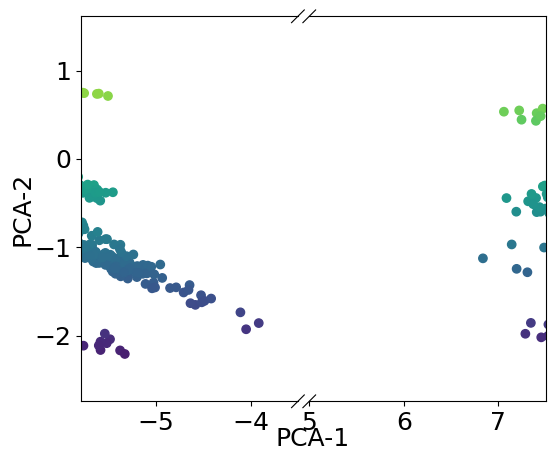

In [361]:
pca3 = PCA(n_components=1)
X_embedded = pca3.fit_transform(fone)

plot_feature(X_embedded, targets, broke=[((-5.8, -3.5), (5.0, 7.5)), None]  )

<Figure size 640x480 with 0 Axes>

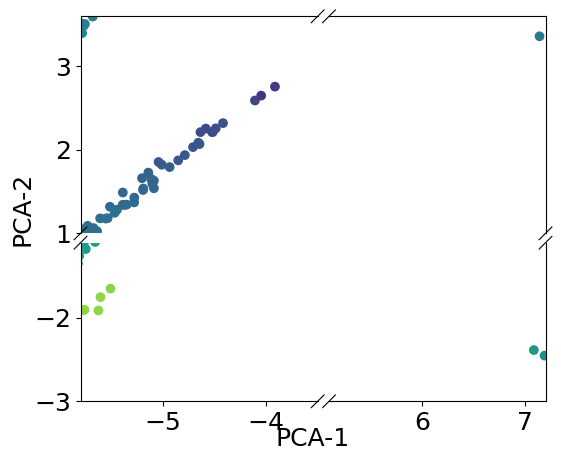

In [362]:
pca3 = PCA(n_components=2)
X_embedded = pca3.fit_transform(fone)

plot_feature(X_embedded, targets, broke=[((-5.8, -3.5), (5.1, 7.2)), ((-3, -1.1), (1.0, 3.6),)]  )

<Figure size 640x480 with 0 Axes>

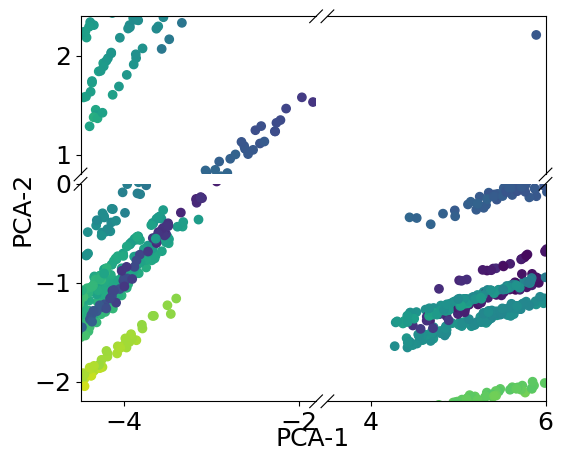

In [363]:
pca3 = PCA(n_components=2)
X_embedded = pca3.fit_transform(ftwo)

plot_feature(X_embedded, targets, broke=[((-4.5, -1.8), (3.5, 6)), ((-2.2, 0), (0.8, 2.4),)]  )

<Figure size 640x480 with 0 Axes>

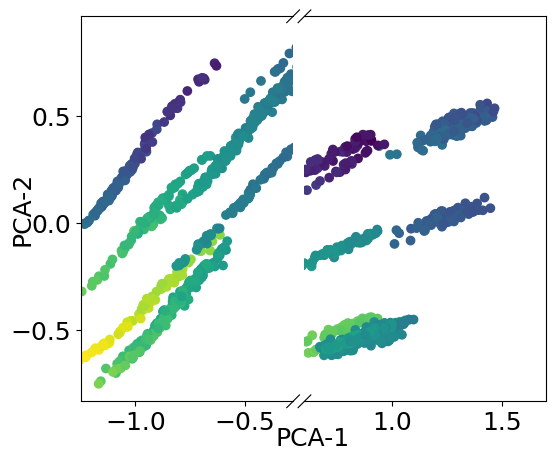

In [364]:
pca3 = PCA(n_components=2)
X_embedded = pca3.fit_transform(fthree)
broke = [((-1.25, -0.28), (.6, 1.7)), None]
plot_feature(X_embedded, targets,  broke= broke)

In [365]:
def calculate_d_band_center(energy, densities):
    # 求和所有态密度
    total_density = np.sum(densities, axis=1)
    # 计算能带的面积
    area = np.trapz(total_density, energy)

    # 计算带心shapeshapeshapeshape
    center = np.trapz(energy * total_density, energy) / area

    return center

In [366]:
def calculate_d_band_center(energy, densities):
    # 求和所有态密度
    total_density = np.sum(densities, axis=1)
    # 计算能带的面积
    area = np.trapz(total_density, energy)

    # 计算带心
    center = np.trapz(energy * total_density, energy) / area

    return center

In [367]:
jjj = 300
datatest = data[jjj].x[0].reshape((-1, 5))
print(data[jjj].y)
datatest.shape

0.26744020000002244


(800, 5)

In [368]:
calculate_d_band_center(-7 + 0.01 * np.array(range(datatest.shape[0])), datatest)

-2.4739450483820637

In [369]:
data[jjj].x[0].shape

(4000,)

In [370]:
datatest

array([[0.00040184, 0.00103655, 0.00041286, 0.00103795, 0.00040437],
       [0.00040835, 0.00104854, 0.00049522, 0.00104982, 0.00041085],
       [0.00041513, 0.0010611 , 0.00059824, 0.00106223, 0.0004176 ],
       ...,
       [0.02312684, 0.01664323, 0.01387319, 0.01672762, 0.023226  ],
       [0.02276578, 0.01656245, 0.0136286 , 0.01664557, 0.0228676 ],
       [0.02241775, 0.01648453, 0.01339436, 0.01656463, 0.02251449]])

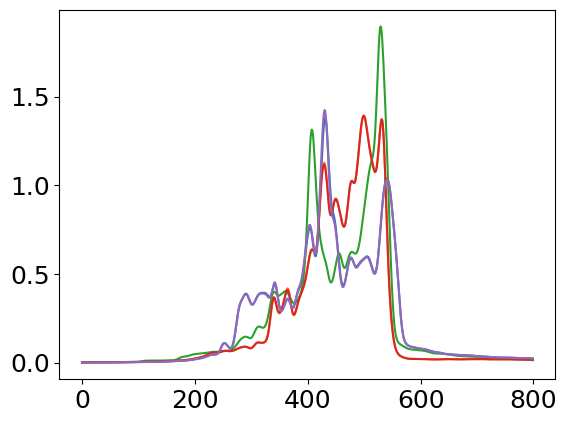

In [371]:
for i in range(datatest.shape[1]):
    plt.plot(range(datatest.shape[0]), datatest[:, i])
plt.show()

In [372]:
datatest

array([[0.00040184, 0.00103655, 0.00041286, 0.00103795, 0.00040437],
       [0.00040835, 0.00104854, 0.00049522, 0.00104982, 0.00041085],
       [0.00041513, 0.0010611 , 0.00059824, 0.00106223, 0.0004176 ],
       ...,
       [0.02312684, 0.01664323, 0.01387319, 0.01672762, 0.023226  ],
       [0.02276578, 0.01656245, 0.0136286 , 0.01664557, 0.0228676 ],
       [0.02241775, 0.01648453, 0.01339436, 0.01656463, 0.02251449]])

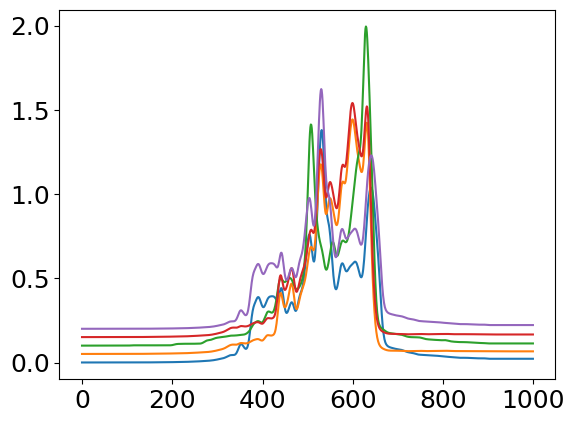

In [373]:
cover = np.zeros((datatest.shape[0] + 200, datatest.shape[1]))
cover[100:-100, :] = datatest
cover[:100, :] = datatest[0, :]
cover[-100:, :] = datatest[-1, :]

for i in range(cover.shape[1]):
    plt.plot(range(cover.shape[0]), cover[:, i] + 0.05 * i)
plt.show()

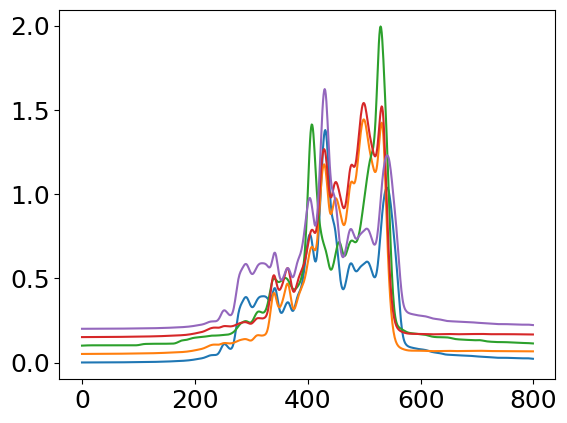

In [374]:
cover_i = cover[100:900, :]
for i in range(cover_i.shape[1]):
    plt.plot(range(cover_i.shape[0]), cover_i[:, i] + 0.05 * i)
plt.show()

In [375]:
datatest.shape[0]

800

In [376]:
import copy

data_height = []

for i in range(21):
    data0 = copy.deepcopy(data[jjj])
    data_i = cover[60 + 4 * i : 60 + 4 * i + datatest.shape[0], :]
    data_i0 = data_i.reshape((1, -1))
    data0.x[:6] = data_i0

    data0.y = -(i - 10) * 0.1
    data_height.append(data0)
data_height[10].x[0].reshape(-1, 5)

array([[0.00040184, 0.00103655, 0.00041286, 0.00103795, 0.00040437],
       [0.00040835, 0.00104854, 0.00049522, 0.00104982, 0.00041085],
       [0.00041513, 0.0010611 , 0.00059824, 0.00106223, 0.0004176 ],
       ...,
       [0.02312684, 0.01664323, 0.01387319, 0.01672762, 0.023226  ],
       [0.02276578, 0.01656245, 0.0136286 , 0.01664557, 0.0228676 ],
       [0.02241775, 0.01648453, 0.01339436, 0.01656463, 0.02251449]])

In [377]:
data_height = np.array(data_height)

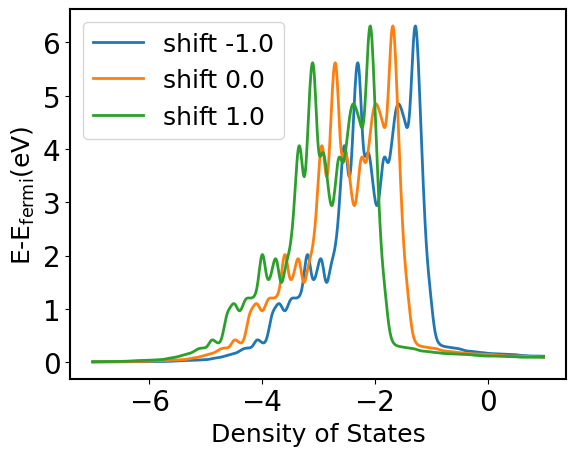

In [378]:
fig, ax = plt.subplots()
for j in [0, 10, 20]:
    p = data_height[j].x[0].reshape(-1, 5)
    ax.plot(
        -7 + 0.010 * np.array(range(p.shape[0])),
        np.sum(p, axis=1),
        label=f"shift {(j-10)*0.1}",
        linewidth=2.0,
    )
ax.set_ylabel('E-' + r'$\regular{E_{fermi}}$' +'(eV)') 
ax.set_xlabel("Density of States")
ax.legend()

plt.xticks(fontsize=20)  # x轴刻度字体大小
plt.yticks(fontsize=20)  # y轴刻度字体大小

# 设置图框线粗细
bwith = 1.5  # 边框宽度设置为2
TK = plt.gca()  # 获取边框
TK.spines["bottom"].set_linewidth(bwith)
TK.spines["left"].set_linewidth(bwith)
TK.spines["top"].set_linewidth(bwith)
TK.spines["right"].set_linewidth(bwith)

plt.show()

In [379]:
loader_h = DisjointLoader(MyGraphDataset(data_height), batch_size=1, epochs=1)

In [380]:
# 对训练集进行预测
predictions = []
targets = []
for batch in loader_h:
    output = GCN_model(batch[0], training=False)
    predictions.append(output)
    targets.append(batch[1])
predictions = np.concatenate(predictions, axis=0)
targets = np.concatenate(targets, axis=0)

/home/zwbai/miniconda3/envs/gcn/lib/python3.9/site-packages/spektral/data/utils.py:221: UserWarning: you are shuffling a 'MyGraphDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


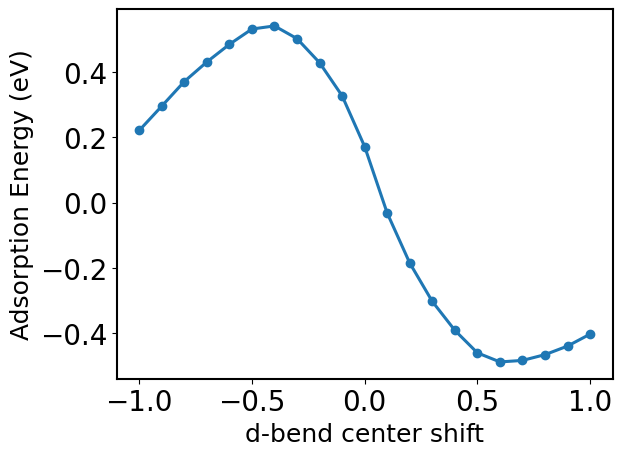

In [381]:
plt.plot(targets, predictions, marker="o", linestyle="-", linewidth =2.2)

plt.xlabel("d-bend center shift")
plt.ylabel("Adsorption Energy (eV)")
plt.xticks(fontsize=20)  # x轴刻度字体大小
plt.yticks(fontsize=20)  # y轴刻度字体大小

# 设置图框线粗细
bwith = 1.5  # 边框宽度设置为2
TK = plt.gca()  # 获取边框
TK.spines["bottom"].set_linewidth(bwith)
TK.spines["left"].set_linewidth(bwith)
TK.spines["top"].set_linewidth(bwith)
TK.spines["right"].set_linewidth(bwith)

In [382]:
datatest.shape

(800, 5)

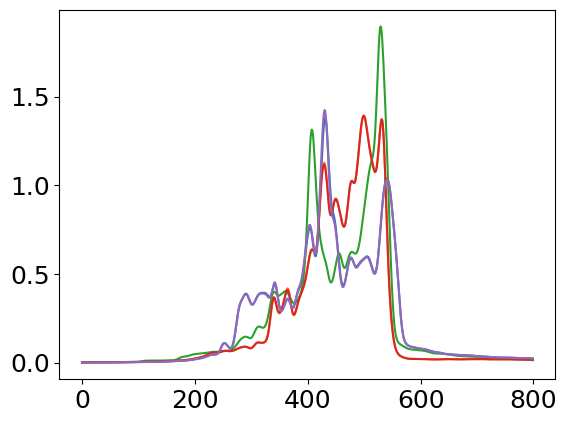

In [383]:
for i in range(datatest.shape[1]):
    plt.plot(range(datatest.shape[0]), datatest[:, i])
plt.show()

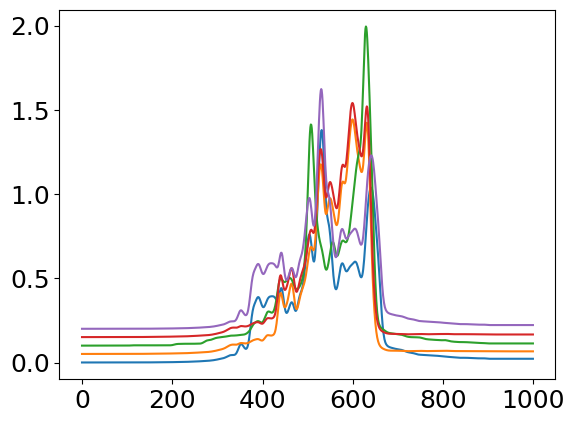

In [384]:
cover = np.zeros((datatest.shape[0] + 200, datatest.shape[1]))
cover[100:-100, :] = datatest
cover[:100, :] = datatest[0, :]
cover[-100:, :] = datatest[-1, :]

for i in range(cover.shape[1]):
    plt.plot(range(cover.shape[0]), cover[:, i] + 0.05 * i)
plt.show()

In [385]:
def interpolate(data, length):
    old_length = data.shape[0]
    x_old = np.linspace(0, 1, old_length)
    x_new = np.linspace(0, 1, length)
    y_new = np.interp(x_new, x_old, data)
    y_new = y_new * old_length / length
    return y_new

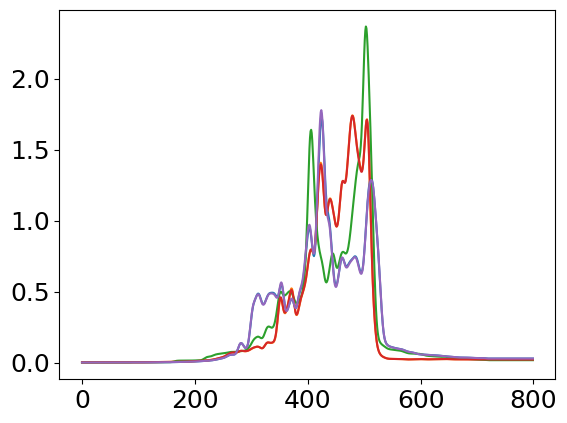

In [386]:
for i in range(cover.shape[1]):
    plt.plot(range(800), interpolate(cover[:, i], 800))
plt.show()

In [387]:
data_i = np.array([interpolate(cover[:, col], 800) for col in range(cover.shape[1])]).T

In [388]:
a = np.array([1, 2, 3, 4])
np.tile(a, 1)[1:-1]

array([2, 3])

In [389]:
data_width = []
for i in range(21):
    data0 = copy.deepcopy(data[jjj])
    data_i = cover[10 * i : cover.shape[0] - 10 * i, :] # 切片截取

    data_i = np.array(
        [interpolate(data_i[:, col], 800) for col in range(data_i.shape[1])]
    ).T

    pce = calculate_d_band_center(np.array(range(data_i.shape[0])), data_i)
    move = round(pce - 456)
    left = -min(move, 0)
    right = max(move, 0)
    up = np.tile(data_i[1, :], (left, 1))
    down = np.tile(data_i[-1, :], (right, 1))
    print(up.shape, data_i.shape, down.shape)
    data_i = np.concatenate((up, data_i, down), axis=0)
    data_i = data_i[right : data_i.shape[0] - left, :]
    data_i0 = data_i.reshape((1, -1))
    data0.x[:6] = data_i0
    data0.y = 800/cover[10 * i : cover.shape[0] - 10 * i, :].shape[0]
    print(cover[10 * i : cover.shape[0] - 10 * i, :].shape[0])
    data_width.append(data0)
data_width = np.array(data_width)

(11, 5) (800, 5) (0, 5)
1000
(10, 5) (800, 5) (0, 5)
980
(10, 5) (800, 5) (0, 5)
960
(9, 5) (800, 5) (0, 5)
940
(8, 5) (800, 5) (0, 5)
920
(8, 5) (800, 5) (0, 5)
900
(7, 5) (800, 5) (0, 5)
880
(6, 5) (800, 5) (0, 5)
860
(5, 5) (800, 5) (0, 5)
840
(4, 5) (800, 5) (0, 5)
820
(3, 5) (800, 5) (0, 5)
800
(2, 5) (800, 5) (0, 5)
780
(1, 5) (800, 5) (0, 5)
760
(0, 5) (800, 5) (0, 5)
740
(0, 5) (800, 5) (1, 5)
720
(0, 5) (800, 5) (2, 5)
700
(0, 5) (800, 5) (4, 5)
680
(0, 5) (800, 5) (5, 5)
660
(0, 5) (800, 5) (7, 5)
640
(0, 5) (800, 5) (8, 5)
620
(0, 5) (800, 5) (10, 5)
600


-0.5593605777175981
-0.5035905156768763
0.40062336322063175


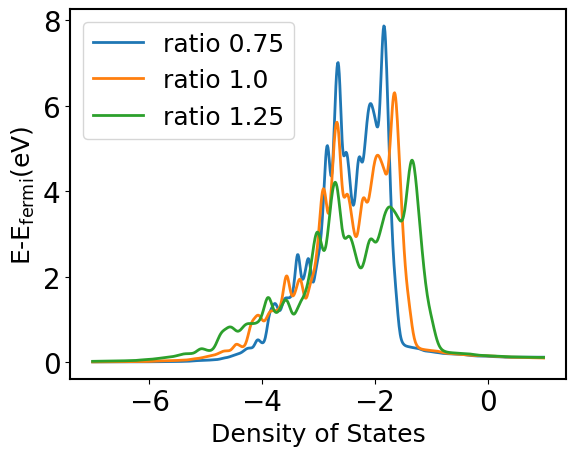

In [390]:
fig, ax = plt.subplots()
for j in [0, 10, 20]:
    p = data_width[j].x[0].reshape(-1, 5)
    pce = calculate_d_band_center(np.array(range(p.shape[0])), p)
    print((pce - 456))
    ax.plot(
        -7 + 0.010 * np.array(range(p.shape[0])),
        np.sum(p, axis=1),
        label=f"ratio {((600+20*j)/800)}",
        linewidth=2.0,
    )
ax.set_ylabel('E-' + r'$\regular{E_{fermi}}$' +'(eV)') 
ax.set_xlabel("Density of States")
ax.legend()

plt.xticks(fontsize=20)  # x轴刻度字体大小
plt.yticks(fontsize=20)  # y轴刻度字体大小

# 设置图框线粗细
bwith = 1.5  # 边框宽度设置为2
TK = plt.gca()  # 获取边框
TK.spines["bottom"].set_linewidth(bwith)
TK.spines["left"].set_linewidth(bwith)
TK.spines["top"].set_linewidth(bwith)
TK.spines["right"].set_linewidth(bwith)

plt.show()

In [391]:
loader_w = DisjointLoader(MyGraphDataset(data_width), batch_size=1, epochs=1)
# 对训练集进行预测
predictions = []
targets = []
for batch in loader_w:
    output = GCN_model(batch[0], training=False)
    predictions.append(output)
    targets.append(batch[1])
predictions = np.concatenate(predictions, axis=0)
targets = np.concatenate(targets, axis=0)

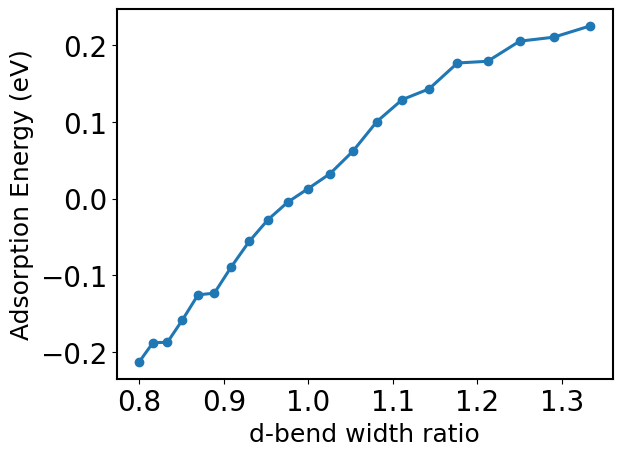

In [392]:
plt.plot(targets, predictions, marker="o", linestyle="-", linewidth =2.2)

plt.xlabel("d-bend width ratio")
plt.ylabel("Adsorption Energy (eV)")

plt.xticks(fontsize=20)  # x轴刻度字体大小
plt.yticks(fontsize=20)  # y轴刻度字体大小

# 设置图框线粗细
bwith = 1.5  # 边框宽度设置为2
TK = plt.gca()  # 获取边框
TK.spines["bottom"].set_linewidth(bwith)
TK.spines["left"].set_linewidth(bwith)
TK.spines["top"].set_linewidth(bwith)
TK.spines["right"].set_linewidth(bwith)

In [393]:
loader_data = DisjointLoader(MyGraphDataset(data_height), batch_size=1, epochs=1)
predictions, targets, feature1, feature2, feature3 = [], [], [], [], []
for batch in loader_data:
    output, f1, f2, f3 = Model_feature(batch[0], training=False)
    predictions.append(output)
    feature1.append(f1)
    feature2.append(f2)
    feature3.append(f3)
    targets.append(batch[1])
predictions = np.concatenate(predictions, axis=0)
targets = np.concatenate(targets, axis=0)
# 组合预测值和真实值
data0 = np.concatenate([predictions, targets], axis=1)

In [394]:
fone = [f.numpy().reshape((1, -1))[0] for f in feature1]
fone = np.array(fone)
fone.shape

(21, 1024)

<Figure size 640x480 with 0 Axes>

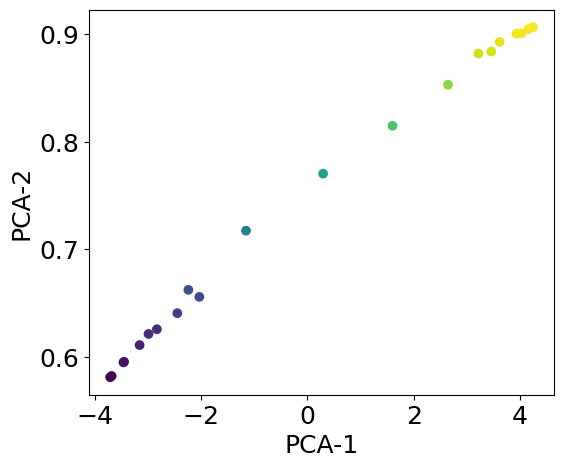

In [395]:
pca3 = PCA(n_components=1)
X_embedded = pca3.fit_transform(fone)
plot_feature(X_embedded, predictions)